In [1]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker # updated
import seaborn as sns
import numpy as np

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

from pprint import pprint

In [2]:
actors_df = pd.read_csv("Craig_portion/Resources/tmdb_5000_credits.csv")
actors_df.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [3]:
movies = pd.read_csv("Craig_portion/Resources/tmdb_5000_movies.csv")
movies_df = pd.DataFrame(movies)
movies_df=movies_df.rename(columns={"overview": "Overview", "vote_average":"Average Vote", "title":"Title", "revenue":"Revenue", "budget":"Budget"})
movies_df.head(3)

,Budget,genres,homepage,id,keywords,original_language,original_title,Overview,popularity,production_companies,production_countries,release_date,Revenue,runtime,spoken_languages,status,tagline,Title,Average Vote,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466


# Number of movies relased in time
Because of significant increase in numbers of movies released in time, we break down the dataset into time buckets. 

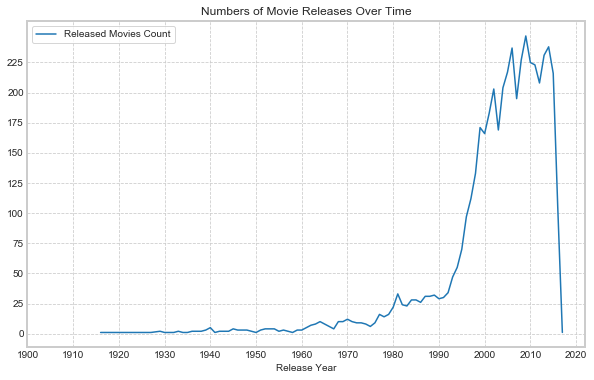

In [4]:
# Add column Release Year
sns.set_style(style='whitegrid',rc={'axes.linewidth': 2.0, 'legend.frameon': True, 'grid.linestyle': u'--',  'legend.scatterpoints': 1, 'font.size': 10, 'axes.labelsize': 10, 'legend.fontsize': 10, 'axes.titlesize': 8, 'xtick.labelsize': 12, 'ytick.labelsize': 10})
movies_df['Release Year']=movies_df['release_date'].str[:4].astype(float)
movies_count_by_year=movies_df.groupby(by="Release Year")["Title"].count().reset_index().rename(columns={"Title":"Released Movies Count"})
plt.figure(figsize=(10,6)) # updated
movies_count_by_year.plot(x="Release Year",y="Released Movies Count", ax = plt.gca()) # updated
plt.xticks(np.arange(1900,2021,10))
plt.yticks(np.arange(0,250,25))
plt.title("Numbers of Movie Releases Over Time")# added
plt.savefig("OutputImages/Numbers of Movie Releases Over Time.png",dpi=300) #added
plt.show()

In [5]:
#updated
year_buckets=[1960,1995]
movie_year_bucket=[]
movie_year_bucket_no=[]
year_buckets_labels=[]
for i in range(0,len(year_buckets)+1):
    if i==0:
        year_buckets_labels.append("before "+str(year_buckets[0]))
    elif i==len(year_buckets):
        year_buckets_labels.append("after "+str(year_buckets[-1]))
    else:
        year_buckets_labels.append(str(year_buckets[i-1])+" to "+str(year_buckets[i]))

for index,row in movies_df.iterrows():
    if row["Release Year"]<year_buckets[0]:
        movie_year_bucket.append(year_buckets_labels[0])
        movie_year_bucket_no.append(1)
    elif row["Release Year"]>=year_buckets[-1]:
        movie_year_bucket.append(year_buckets_labels[-1])
        movie_year_bucket_no.append(len(year_buckets)+1)
    else:
        ok=False
        for i in range(len(year_buckets)-1):
            if(year_buckets[i]<=row["Release Year"]<year_buckets[i+1]):
                movie_year_bucket.append(year_buckets_labels[i+1])
                movie_year_bucket_no.append(i+2)                
                ok=True
        if(ok==False):
            movie_year_bucket.append("undefined")
            movie_year_bucket_no.append(0)
       

movies_df["Years"]=movie_year_bucket
movies_df["Release Years Bucket"]=movie_year_bucket_no


In [6]:
movies_money_df=movies_df.loc[(movies_df["status"]=="Released") & (movies_df["Average Vote"]>0) & (movies_df["Budget"]>0)& (movies_df["Revenue"]>0),["Title","Release Year", "Years", "Release Years Bucket", "Budget","Revenue","Average Vote"]]
# cteate a column with present day money value for Revenue
movies_money_df["Revenue, USD mln"]=movies_money_df["Revenue"]/1000000 #added
movies_money_df["Budget, USD mln"]=movies_money_df["Budget"]/1000000 #added
for index,row in movies_money_df.iterrows():
   movies_money_df.at[index,"Revenue Adjusted, USD mln"]=row["Revenue, USD mln"]*(1.03**(2017-row["Release Year"])) #updated all
   movies_money_df.at[index,"Revenue Adjusted"]=row["Revenue"]*(1.03**(2017-row["Release Year"])) #updated all
   movies_money_df.at[index,"Budget Adjusted, USD mln"]=row["Budget, USD mln"]*(1.03**(2017-row["Release Year"])) #updated all

# Clean-up of budget and revenue data (added)

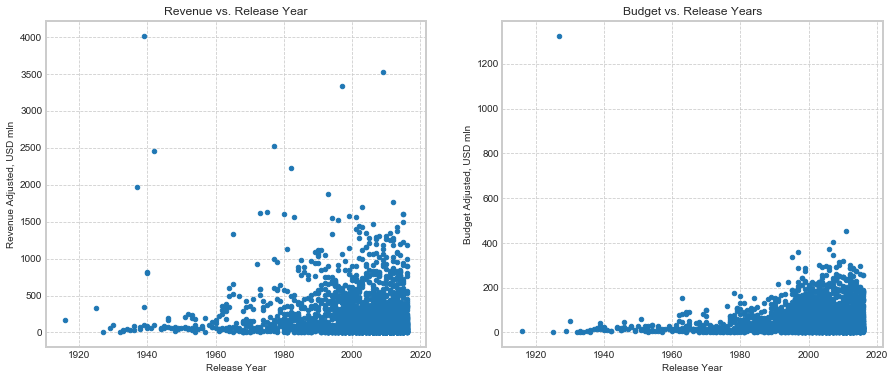

In [7]:
#added
fig, (ax1,ax2) = plt.subplots(1,2, sharey=False, sharex=True, figsize=(15,6))
movies_money_df.plot(x="Release Year",y="Revenue Adjusted, USD mln",kind="scatter", ax = ax1)
movies_money_df.plot(x="Release Year",y="Budget Adjusted, USD mln",kind="scatter", ax = ax2)
ax1.ticklabel_format(style='plain',axis='y')
ax2.ticklabel_format(style='plain',axis='y')
ax1.set_title('Revenue vs. Release Year')
ax2.set_title('Budget vs. Release Years')
plt.savefig("OutputImages/Budget and Revenue vs Release Year - with outliers.png",dpi=300) #added
plt.show()

# Revenues
Because of large difference in revenues, we break down movies into revenue buckets.
Revenues were adjusted to current money value at inflation rate of 3% per year. 

Movies with higest revenues are listed below.
Snow White and the Seven Dwarfs, Gone with the Wind, Bambi - wikipedia confirms revenues are correct.
Metropolis - budget as well as revenue data on the film  is confirmed on wikipedia.

In [8]:
# adj_revenue_mean=np.mean(movies_money_df["Revenue Adjusted"])
# adj_revenue_std=np.std(movies_money_df["Revenue Adjusted"])
movies_money_df.sort_values(["Revenue Adjusted, USD mln"],ascending=[False],inplace=True)
movies_money_df.head(7)

,Title,Release Year,Years,Release Years Bucket,Budget,Revenue,Average Vote,"Revenue, USD mln","Budget, USD mln","Revenue Adjusted, USD mln",Revenue Adjusted,"Budget Adjusted, USD mln"
3813,Gone with the Wind,1939.0,before 1960,1,4000000,400176459,7.7,400.176459,4.000000,4013.793858,4.013794e+09,40.120240
0,Avatar,2009.0,after 1995,3,237000000,2787965087,7.2,2787.965087,237.000000,3531.710760,3.531711e+09,300.224509
25,Titanic,1997.0,after 1995,3,200000000,1845034188,7.5,1845.034188,200.000000,3332.336975,3.332337e+09,361.222247
2912,Star Wars,1977.0,1960 to 1995,2,11000000,775398007,8.1,775.398007,11.000000,2529.377603,2.529378e+09,35.882416
4441,Bambi,1942.0,before 1960,1,858000,267447150,6.8,267.447150,0.858000,2454.877510,2.454878e+09,7.875518
2967,E.T. the Extra-Terrestrial,1982.0,1960 to 1995,2,10500000,792910554,7.3,792.910554,10.500000,2231.141238,2.231141e+09,29.545556
4259,Snow White and the Seven Dwarfs,1937.0,before 1960,1,1488423,184925486,6.9,184.925486,1.488423,1967.771858,1.967772e+09,15.838146


In [9]:
#added
movies_money_df["Outlier"]=False

i=0
for index,row in movies_money_df.iterrows():
    movies_money_df.loc[index,"Outlier"]=True
    i=i+1
    if i==7:
        break

In [10]:
#added
movies_money_df.sort_values(["Budget Adjusted, USD mln"],ascending=[False],inplace=True)# updated
movies_money_df.head(1)# updated

,Title,Release Year,Years,Release Years Bucket,Budget,Revenue,Average Vote,"Revenue, USD mln","Budget, USD mln","Revenue Adjusted, USD mln",Revenue Adjusted,"Budget Adjusted, USD mln",Outlier
2638,Metropolis,1927.0,before 1960,1,92620000,650422,8.0,0.650422,92.62,9.301338,9.301338e+06,1324.509264,False


In [11]:
i=0
for index,row in movies_money_df.iterrows():
    movies_money_df.loc[index,"Outlier"]=True
    i=i+1
    if i==1:
        break
        

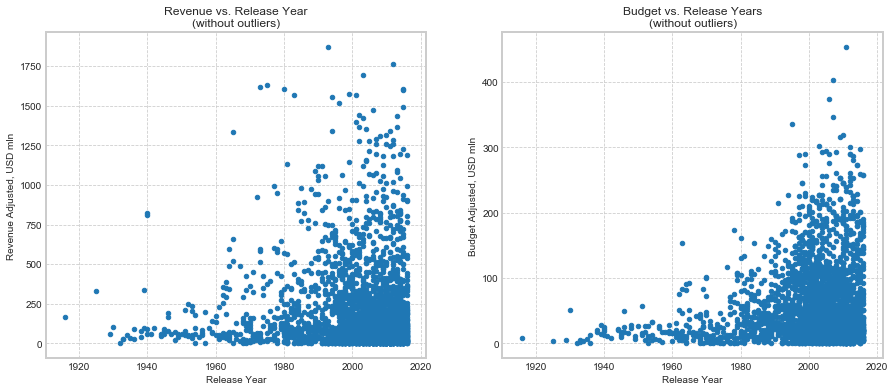

In [12]:
#added
fig, (ax1,ax2) = plt.subplots(1,2, sharey=False, sharex=True, figsize=(15,6))
movies_money_df[movies_money_df["Outlier"]==False].plot(x="Release Year",y="Revenue Adjusted, USD mln",kind="scatter", ax = ax1)
movies_money_df[movies_money_df["Outlier"]==False].plot(x="Release Year",y="Budget Adjusted, USD mln",kind="scatter", ax = ax2)
ax1.set_title('Revenue vs. Release Year\n(without outliers)')
ax2.set_title('Budget vs. Release Years\n(without outliers)')
plt.savefig("OutputImages/Budget and Revenue vs Release Year.png",dpi=300) #added
plt.show()

In [13]:
#modified, replace budget to budget
budget_buckets=[0.5,10,100] #updated
budget_bucket=[]
budget_bucket_no=[]
budget_buckets_labels=[]
units_str="USD mln"
for i in range(0,len(budget_buckets)+1):
    if i==0:
        budget_buckets_labels.append("<"+str(budget_buckets[0])+" "+units_str)
    elif i==len(budget_buckets):
        budget_buckets_labels.append(">"+str(budget_buckets[-1])+" "+units_str)
    else:
        budget_buckets_labels.append(str(budget_buckets[i-1])+"-"+str(budget_buckets[i])+" "+units_str)
        
for index,row in movies_money_df.iterrows():
    if row["Budget Adjusted, USD mln"]<budget_buckets[0]:
        budget_bucket.append(budget_buckets_labels[0])
        budget_bucket_no.append(1)
    elif row["Budget Adjusted, USD mln"]>=budget_buckets[-1]:
        budget_bucket.append(budget_buckets_labels[-1])
        budget_bucket_no.append(len(budget_buckets)+1)
    else:
        ok=False
        for i in range(len(budget_buckets)-1):#updated
            if(budget_buckets[i]<=row["Budget Adjusted, USD mln"]<budget_buckets[i+1]):
                budget_bucket.append(budget_buckets_labels[i+1])
                budget_bucket_no.append(i+2)
                ok=True
        if(ok==False):
            budget_bucket.append("undefined")
            budget_bucket_no.append(0)
            

movies_money_df["Budget Tier"]=budget_bucket
movies_money_df["Budget Tier No"]=budget_bucket_no

# Revenues by release year and revenue tiers

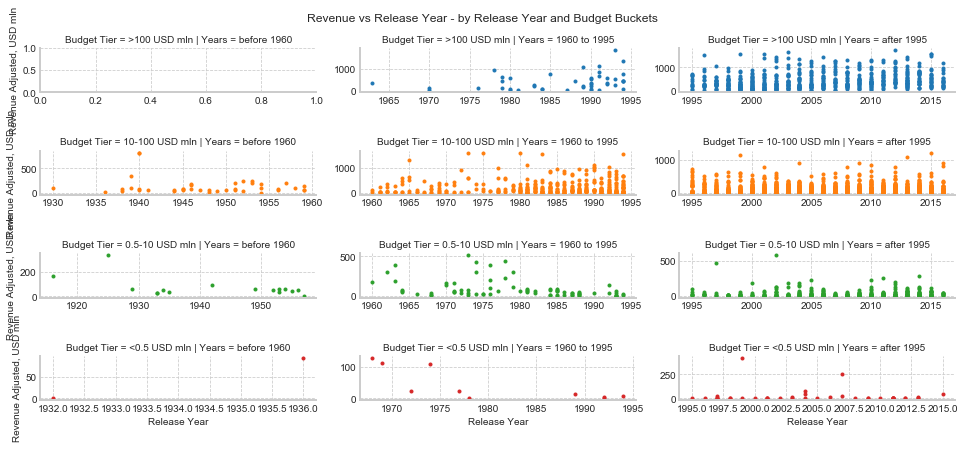

In [14]:
g = sns.FacetGrid(movies_money_df[~movies_money_df["Outlier"]], row="Budget Tier", row_order=list(reversed(budget_buckets_labels)), col="Years", col_order=year_buckets_labels, sharex=False, sharey=False, hue="Budget Tier", hue_order=list(reversed(budget_buckets_labels)), size=1.5,aspect=3) #updated
g = g.map(plt.scatter, 'Release Year', 'Revenue Adjusted, USD mln', marker='.')
plt.suptitle("Revenue vs Release Year - by Release Year and Budget Buckets")
plt.savefig("OutputImages/Revenue vs Release Year - by Release Year and Budget Buckets.png",dpi=300) #added
g.fig.subplots_adjust(top=.9)
plt.show()

# Relationship between movie budget and movie rating
Budget is shown in today's money adjusted to 3% inflation.
As seen from the plots, budgets are not the determinig factor for movie rating. In some cases high budgets did not ensure high rating.


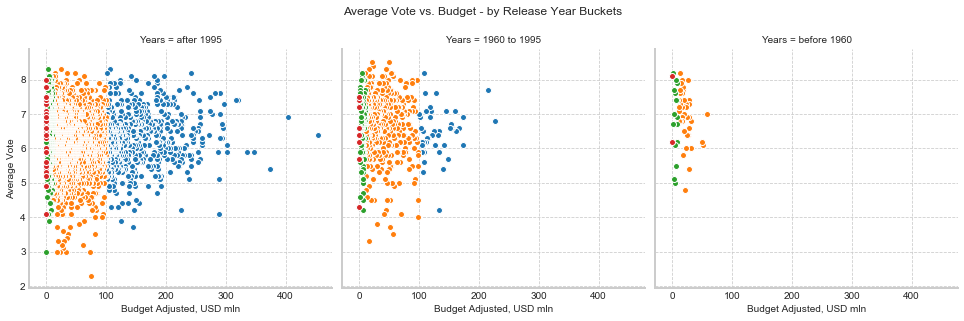

In [15]:
g = sns.FacetGrid(movies_money_df[movies_money_df["Outlier"]==False], col="Years", sharex=True, sharey=True, hue="Budget Tier", hue_order=list(reversed(budget_buckets_labels)), size=4.5) #updated
g = g.map(plt.scatter, 'Budget Adjusted, USD mln', 'Average Vote', edgecolor="w", marker='o')#updated
plt.suptitle("Average Vote vs. Budget - by Release Year Buckets")
g.fig.subplots_adjust(top=.85)
plt.savefig("OutputImages/Average Vote vs. Budget - by Release Year Buckets.png",dpi=300) #added
plt.show()

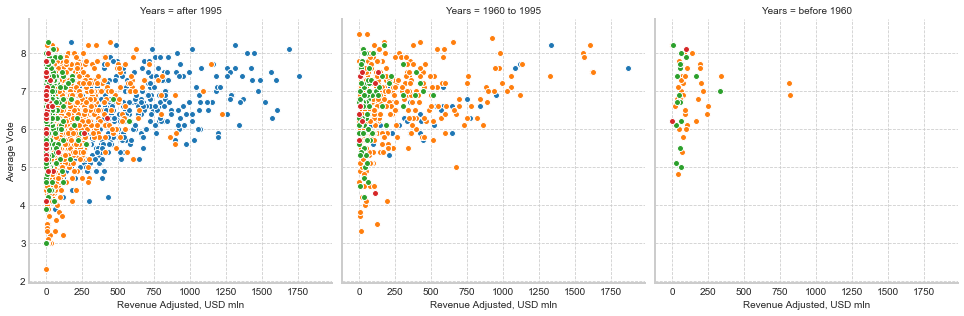

In [16]:

g = sns.FacetGrid(movies_money_df[movies_money_df["Outlier"]==False], col="Years", sharex=True, sharey=True, hue="Budget Tier", hue_order=list(reversed(budget_buckets_labels)),size=4.5) #updated
g = g.map(plt.scatter, 'Revenue Adjusted, USD mln', 'Average Vote', edgecolor="w", marker='o')#updated
plt.show()

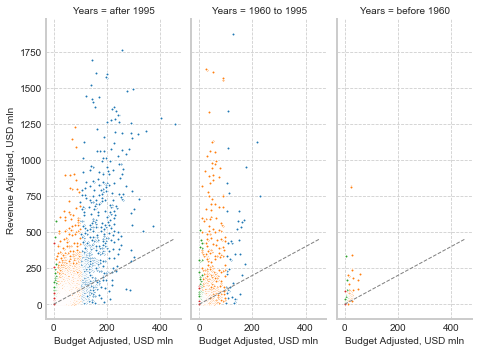

In [17]:
#added
#movies_money_df.sort_values(["Release Years Bucket"],ascending=[True],inplace=True)
max_budget=movies_money_df[movies_money_df["Outlier"]==False]["Budget Adjusted, USD mln"].values.max()
g = sns.FacetGrid(movies_money_df[movies_money_df["Outlier"]==False], col="Years", hue="Budget Tier", hue_order=list(reversed(budget_buckets_labels)), sharex=True, sharey=True, size=5,aspect=0.45) 
g = g.map(plt.scatter,  'Budget Adjusted, USD mln', 'Revenue Adjusted, USD mln',edgecolor="w",  marker='.')
for i, ax in enumerate(g.axes.flat):
    ax.plot([0,max_budget], [0,max_budget], color='gray', linestyle='dashed', linewidth=1, markersize=0)
plt.show()

In [18]:
# create datafarme with movie actors - first 3 for each movie

for index,row in actors_df.iterrows():
    given_movies_actor_value=eval(row['cast'])
    given_movie_actors_df = pd.DataFrame(given_movies_actor_value)
    given_movie_actors_df["Title"]=row['title']
    try:
        given_movie_actors_df.drop(axis=1,columns=['cast_id','character','credit_id','gender','id','order'],inplace=True)
    except:
        pass
    
    if(index==0):
        movie_actor_df=given_movie_actors_df.iloc[0:3]
    else:
        movie_actor_df=movie_actor_df.append(given_movie_actors_df.iloc[0:3])

movie_actor_df.rename(columns={"name":"Actor"},inplace=True)   
movie_actor_df.head()   

,Title,Actor
0,Avatar,Sam Worthington
1,Avatar,Zoe Saldana
2,Avatar,Sigourney Weaver
0,Pirates of the Caribbean: At World's End,Johnny Depp
1,Pirates of the Caribbean: At World's End,Orlando Bloom


In [19]:
movies_money_df.head()

,Title,Release Year,Years,Release Years Bucket,Budget,Revenue,Average Vote,"Revenue, USD mln","Budget, USD mln","Revenue Adjusted, USD mln",Revenue Adjusted,"Budget Adjusted, USD mln",Outlier,Budget Tier,Budget Tier No
2638,Metropolis,1927.0,before 1960,1,92620000,650422,8.0,0.650422,92.62,9.301338,9.301338e+06,1324.509264,True,>100 USD mln,4
17,Pirates of the Caribbean: On Stranger Tides,2011.0,after 1995,3,380000000,1045713802,6.4,1045.713802,380.00,1248.636967,1.248637e+09,453.739873,False,>100 USD mln,4
1,Pirates of the Caribbean: At World's End,2007.0,after 1995,3,300000000,961000000,6.9,961.000000,300.00,1291.503641,1.291504e+09,403.174914,False,>100 USD mln,4
10,Superman Returns,2006.0,after 1995,3,270000000,391081192,5.4,391.081192,270.00,541.347832,5.413478e+08,373.743145,False,>100 USD mln,4
25,Titanic,1997.0,after 1995,3,200000000,1845034188,7.5,1845.034188,200.00,3332.336975,3.332337e+09,361.222247,True,>100 USD mln,4


In [20]:
# add max total weighted revenue of prior movies by actor (first 3 in the cast), as a measure of prior popularity of the actors starring
movie_max_avg_rev_by_actor=[]

for index,row in movies_money_df.iterrows():
    curr_movie_actors_df=movie_actor_df.loc[movie_actor_df['Title']==row['Title']]
    curr_movie_actors_all_movies_df=pd.DataFrame.merge(curr_movie_actors_df,movie_actor_df,on='Actor')
    prior_movies_df=movies_money_df.loc[movies_money_df['Release Year']<row['Release Year']]
    curr_movie_actors_all_prior_movies_df=pd.DataFrame.merge(curr_movie_actors_all_movies_df,prior_movies_df,left_on="Title_y", right_on="Title")

    #added
    curr_movie_actors_all_prior_movies_df["Prior Movie Weight"]=1-2*(row['Release Year']-curr_movie_actors_all_prior_movies_df["Release Year"])/100
    curr_movie_actors_all_prior_movies_df["Weighted Revenue Adjusted, USD mln"]=curr_movie_actors_all_prior_movies_df["Prior Movie Weight"]*curr_movie_actors_all_prior_movies_df["Revenue Adjusted, USD mln"]
    
    curr_movie_actors_all_prior_movies_before_gr_ser=curr_movie_actors_all_prior_movies_df.groupby(by="Actor").sum()#updated
    
   
    try:
        max_actor_avg_prior_rev=curr_movie_actors_all_prior_movies_before_gr_ser["Weighted Revenue Adjusted, USD mln"].max() #updated
        movie_max_avg_rev_by_actor.append(max_actor_avg_prior_rev)
    except:
        movie_max_avg_rev_by_actor.append(0)

se = pd.Series(movie_max_avg_rev_by_actor)
movies_money_df['Starring Actors Popularity'] = se.values


# Relationship between prior popularity of starring actors and movies' revenues
As a measure of actor's popularity, we used the maximum avg revenue of movies in which each of starring actors (first 3 inn the cast) were starring previously (first 3 in the cast).
We can see that actor's popularity is not a detrmining factor for movie success. 

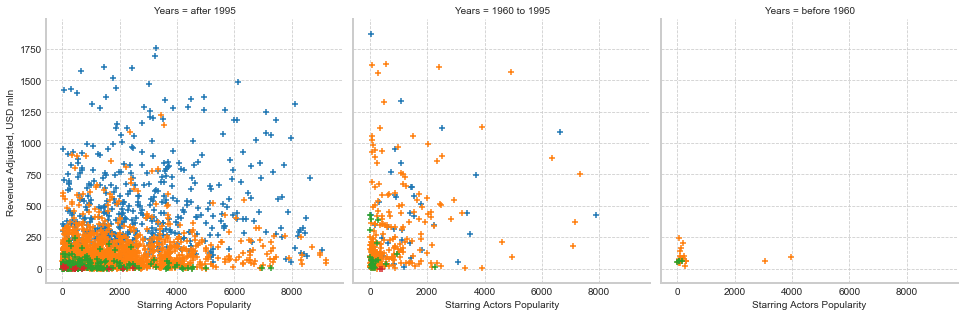

In [21]:
#movies_money_df.sort_values(["Revenue Tier No", "Release Years Bucket"],ascending=[False, True],inplace=True) #updated
#g = sns.FacetGrid(movies_money_df, row="Revenue Tier", col="Years", sharex=True, sharey=False, size=3,aspect=2) #updated
#g = g.map(plt.scatter, "Starring Actors Popularity", "Revenue Adjusted", edgecolor="w")

#movies_money_df.sort_values(["Budget Tier","Release Years Bucket"],ascending=[True,True],inplace=True) #updated
#movies_money_df.sort_values("Release Years Bucket",ascending=True,inplace=True) #updated
g = sns.FacetGrid(movies_money_df[movies_money_df["Outlier"]==False], col="Years", hue="Budget Tier", hue_order=list(reversed(budget_buckets_labels)), sharex=True, sharey=True, size=4.5) #updated
g = g.map(plt.scatter, "Starring Actors Popularity", "Revenue Adjusted, USD mln", marker='+',edgecolor="w")

plt.show()

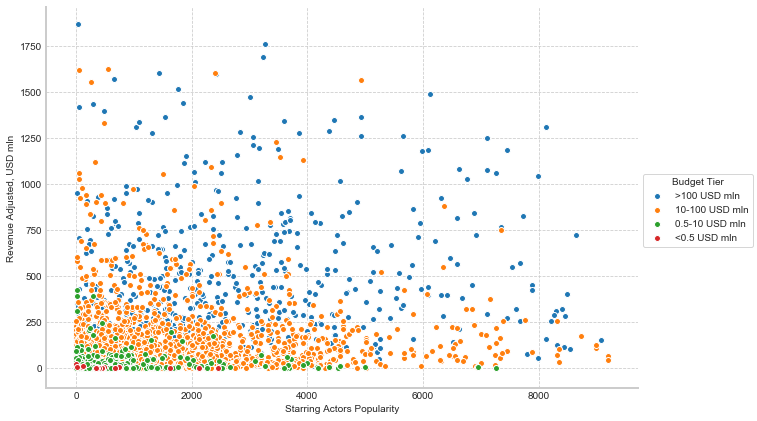

In [22]:
#added
g = sns.pairplot(movies_money_df[movies_money_df["Outlier"]==False], x_vars="Starring Actors Popularity", y_vars="Revenue Adjusted, USD mln", hue="Budget Tier",hue_order=list(reversed(budget_buckets_labels)),markers='o',size=6,aspect=1.5)

plt.show()



In [23]:
#added
#worst performers
def get_movie_actors(pop_from,pop_to,rev_from,rev_to):
    movies_actors=[]
    movies=movies_money_df[(movies_money_df["Starring Actors Popularity"]>=pop_from) & (movies_money_df["Starring Actors Popularity"]<=pop_to) & (movies_money_df["Revenue Adjusted, USD mln"]<=rev_to)& (movies_money_df["Revenue Adjusted, USD mln"]>=rev_from)][["Title","Release Year","Budget","Revenue","Budget Adjusted, USD mln", "Revenue Adjusted, USD mln"]]
    for index,row in movies.iterrows():
        movies_actors.append(", ".join(movie_actor_df.loc[movie_actor_df["Title"]==row["Title"],"Actor"]))
    movies["Cast"]=movies_actors
    return movies;

print("Some of worst performing movies with top cast")
get_movie_actors(8000,999999999,0,100).sort_values(["Revenue Adjusted, USD mln"],ascending=[True])



#movies_actors=[]
#movies=movies_money_df[(movies_money_df["Starring Actors Popularity"]>13000) & (movies_money_df["Revenue Adjusted, USD mln"]<250)][["Title","Release Year","Budget","Revenue","Budget Adjusted, USD mln", "Revenue Adjusted, USD mln"]]
#for index,row in movies.iterrows():
#    movies_actors.append(", ".join(movie_actor_df.loc[movie_actor_df["Title"]==row["Title"],"Actor"]))
#movies["Cast"]=movies_actors
#movies

Some of worst performing movies with top cast


,Title,Release Year,Budget,Revenue,"Budget Adjusted, USD mln","Revenue Adjusted, USD mln",Cast
783,Mortdecai,2015.0,60000000,30418560,63.654000,32.271050,"Johnny Depp, Gwyneth Paltrow, Ewan McGregor"
1612,Larry Crowne,2011.0,30000000,36160375,35.821569,43.177379,"Tom Hanks, Julia Roberts, Bryan Cranston"
1231,Extremely Loud & Incredibly Close,2011.0,40000000,55247881,47.762092,65.968859,"Thomas Horn, Tom Hanks, Sandra Bullock"
598,Rock of Ages,2012.0,75000000,59418613,86.945556,68.882458,"Julianne Hough, Diego Boneta, Tom Cruise"


In [24]:
print("Some of top performing movies without high profile stars at the time of movie release")
get_movie_actors(0,25,500,999999999).sort_values(["Revenue Adjusted, USD mln"],ascending=[False])

Some of top performing movies without high profile stars at the time of movie release


,Title,Release Year,Budget,Revenue,"Budget Adjusted, USD mln","Revenue Adjusted, USD mln",Cast
111,Transformers,2007.0,150000000,709709780,201.587457,953.790598,"Shia LaBeouf, Josh Duhamel, Megan Fox"
1154,Fifty Shades of Grey,2015.0,40000000,571006128,42.436000,605.780401,"Dakota Johnson, Jamie Dornan, Jennifer Ehle"
1356,The Hangover,2009.0,35000000,459270619,44.336953,581.790279,"Bradley Cooper, Ed Helms, Zach Galifianakis"


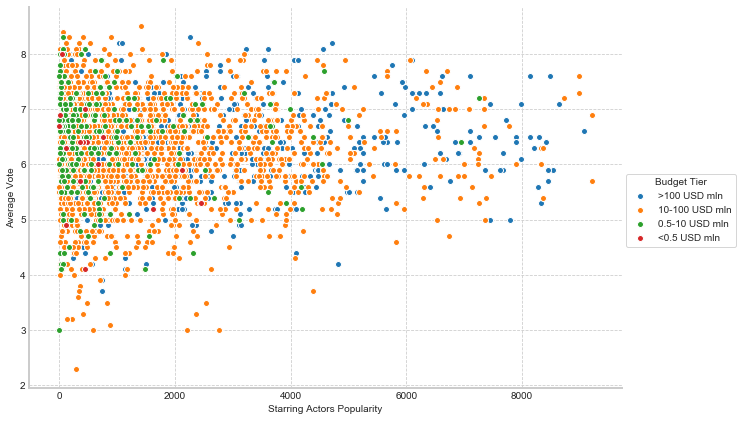

In [25]:
g = sns.pairplot(movies_money_df[movies_money_df["Outlier"]==False], x_vars="Starring Actors Popularity", y_vars="Average Vote", hue="Budget Tier", hue_order=list(reversed(budget_buckets_labels)),size=6,aspect=1.5)
plt.show()

In [26]:
movie_actor_df.dropna(inplace=True)
movie_actor_df.describe()

,Title,Actor
count,14250,14250
unique,4757,5687
top,Out of the Blue,Robert De Niro
freq,6,46


In [27]:
# create datafarme with movies-genres

for index,row in movies_df.iterrows():
    given_movies_genre_value=eval(row['genres'])
    given_movie_genres_df = pd.DataFrame(given_movies_genre_value)
    given_movie_genres_df["Title"]=row['Title']
    try:
        given_movie_genres_df.drop(axis=1,columns=['id'],inplace=True)
    except:
        pass
    
    if(index==0):
        movie_genre_df=given_movie_genres_df
    else:
        movie_genre_df=movie_genre_df.append(given_movie_genres_df)

movie_genre_df.rename(columns={"name":"Genre"},inplace=True)   
movie_genre_df.head()  

,Title,Genre
0,Avatar,Action
1,Avatar,Adventure
2,Avatar,Fantasy
3,Avatar,Science Fiction
0,Pirates of the Caribbean: At World's End,Adventure


In [28]:
movie_genre_df.dropna(inplace=True)                                                   
movie_genre_df.describe()

,Title,Genre
count,12160,12160
unique,4772,20
top,The Host,Drama
freq,8,2297


In [29]:
genres_list={"Mood":['Comedy','Thriller','Horror','Drama','Action','Fantasy','Mystery'],
"Concept":['Crime','Science Fiction','Family','Romance','Adventure','Western','War','History']}
movie_genre_df["Genre"].value_counts()
genres_list_all=movie_genre_df["Genre"].unique()
genres_list_all

array(['Action', 'Adventure', 'Fantasy', 'Science Fiction', 'Crime',
       'Drama', 'Thriller', 'Animation', 'Family', 'Western', 'Comedy',
       'Romance', 'Horror', 'Mystery', 'History', 'War', 'Music',
       'Documentary', 'Foreign', 'TV Movie'], dtype=object)

# Success of genres

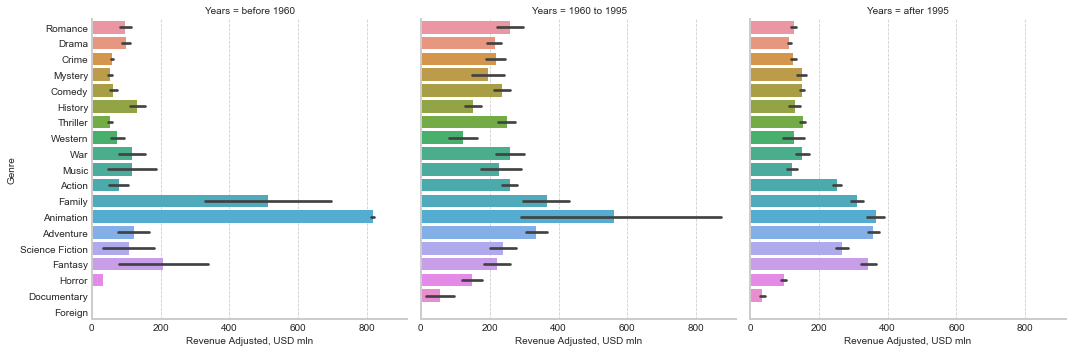

In [30]:
#added
genre_revenues_df=pd.DataFrame.merge(movie_genre_df, movies_money_df.loc[movies_money_df["Outlier"]==False],on="Title")
genre_revenues_df.sort_values(["Release Years Bucket"],ascending=[True],inplace=True)
g = sns.factorplot(y="Genre", x="Revenue Adjusted, USD mln", col="Years", data=genre_revenues_df,kind="bar", ci=68, size=5,sharey=True,sharex=True, orient="h")


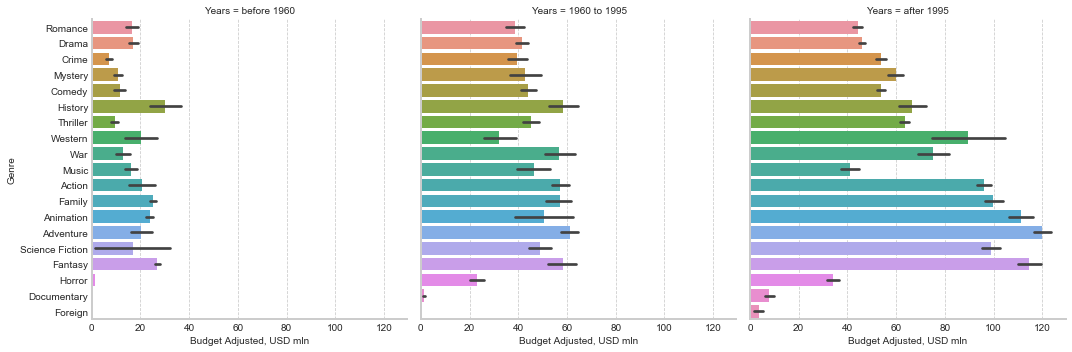

In [31]:
genre_revenues_df=pd.DataFrame.merge(movie_genre_df, movies_money_df.loc[movies_money_df["Outlier"]==False],on="Title")
genre_revenues_df.sort_values(["Release Years Bucket"],ascending=[True],inplace=True)
g = sns.factorplot(y="Genre", x="Budget Adjusted, USD mln", col="Years", data=genre_revenues_df,kind="bar", ci=68, size=5,sharey=True,sharex=True, orient="h")


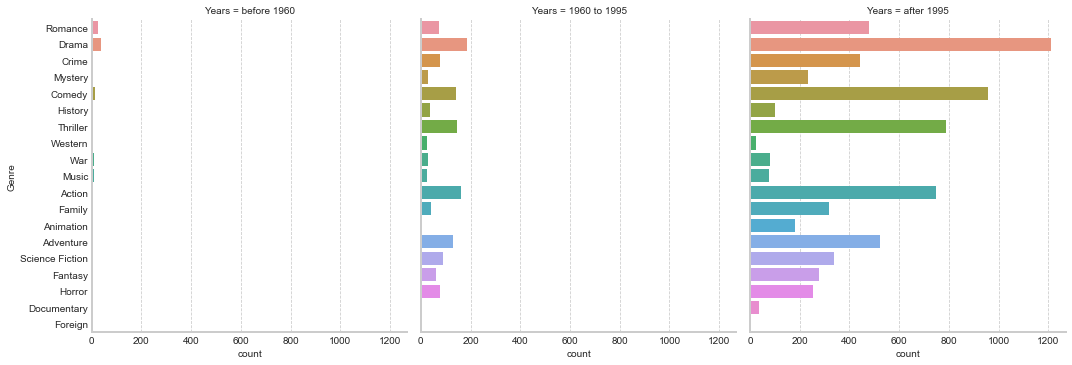

In [32]:
genre_revenues_df=pd.DataFrame.merge(movie_genre_df, movies_money_df.loc[movies_money_df["Outlier"]==False],on="Title")
genre_revenues_df.sort_values(["Release Years Bucket"],ascending=[True],inplace=True)
g = sns.factorplot(y="Genre", x=None, col="Years", data=genre_revenues_df,kind="count",size=5,sharey=True,sharex=True, orient="h")


In [33]:
actor_genres_df=pd.DataFrame.merge(movie_actor_df,movie_genre_df, on="Title")
actor_genres_df.dropna(inplace=True)
actor_genres_df.head()

,Title,Actor,Genre
0,Avatar,Sam Worthington,Action
1,Avatar,Sam Worthington,Adventure
2,Avatar,Sam Worthington,Fantasy
3,Avatar,Sam Worthington,Science Fiction
4,Avatar,Zoe Saldana,Action


In [34]:
actor_genres_counts=actor_genres_df.groupby(by=["Actor","Genre"]).count()
actor_genres_counts.rename(columns={"Title":"Movies Count"},inplace=True)
actor_genres_counts.reset_index(inplace=True)
actor_genres_counts.head()

,Actor,Genre,Movies Count
0,"""Weird Al"" Yankovic",Comedy,1
1,50 Cent,Action,1
2,50 Cent,Crime,1
3,50 Cent,Drama,2
4,50 Cent,Thriller,1


# Actors starred most, by movie genre 

In [35]:
actors_name=[]
actors_genre=[]
actors_genre_count=[]

for genre in genres_list_all:
    given_genre_actors=actor_genres_counts.loc[actor_genres_counts["Genre"]==genre]
    given_genre_actors_max=given_genre_actors.loc[given_genre_actors["Movies Count"].idxmax()]
    actors_genre.append(genre)
    actors_name.append(given_genre_actors_max["Actor"])
    actors_genre_count.append(given_genre_actors_max["Movies Count"])


actors_genre_top_df=pd.DataFrame.from_dict({'Actor': actors_name, 'Genre': actors_genre, 'Count': actors_genre_count})
actors_genre_top_df.loc[actors_genre_top_df["Genre"].isin(genres_list["Mood"])].sort_values(["Count"],ascending=[False])


,Actor,Count,Genre
10,Will Ferrell,26,Comedy
5,Matt Damon,25,Drama
6,Bruce Willis,21,Thriller
0,Arnold Schwarzenegger,20,Action
2,Johnny Depp,11,Fantasy
12,Robert Englund,9,Horror
13,Liam Neeson,7,Mystery
